# Kinetics Simulator

This notebook allows you to simulate the kinetics of a chemical reaction network.

## Before You Begin

Ensure you have both [anaconda](https://docs.conda.io/projects/conda/en/latest/index.html) and [git](https://git-scm.com/downloads) installed. Anaconda will allow you to install the requisite python software libraires that are needed to run the code. Git will allow you to easily access newer versions of the code as they come out.

## Setup

Before running any cells, you will need to first create a virtual environment for this notebook. To do this, navigate to the directory containing this notebook and run the following command in your terminal:

<code>conda env create -f environment.yml</code>

## Theory

As enzymologists, we are often interested in simulating the behaviour of a system of coupled enzymatic reactions. If we have prior knowledge of the rate constants associated with these individual reactions, we can model their behaviours using mass action or Michaelis Menten kinetics. For a chemical reaction network, this is done by first defining a vector of rates, where each element corresponds to the time derivative of a chemical species. We can always construct such a vector using chemical rate laws and the Michaelis Menten equation. After computing this rate vector, we can numerically integrate to solve for a concentration vector for each timepoint. 

## Running the Notebook

To run a kinetic simulation, you will need to define an array of timepoints and three dictionaries. The first dictionary, <code>mass_action_dict</code>, contains all the elementary reactions modeled using mass action kinetics and their corresponding rate constants. The enzymatic reactions modelled by Michaelis-Menten kinetics are contained in the <code>michaelis_menten_dict</code>. The third and final dictionary, <code>initial_values</code>, defines the initial state of the chemical reaction network.

When writing these dictionaries, ensure you abide by the following conventions:
1) Substrates names and rate constant names should have no spaces and none of the following special characters: *, ->, +, <->. Note that all names should be unique.
2) All substrates, characters, and stoichiometric coefficients should be separated by a single space.
3) Reversible reactions are designated by a '<->' character. The two rate constants are associated with the forward and reverse reactions respectively.
4) Initial substrate concentrations left undefined will automatically be set to zero.
5) If you have no Michaelis Menten or mass action reactions, it is ok to leave their respective dictionaries empty.
6) The <code>plot_kwargs</code> dictionary is completely optional. If you would like more control over the appearance of your plot, feel free to add key-value pairs as appropriate.

In [1]:
import numpy as np
from collections import OrderedDict
from src.chemicalkinetics import ChemicalReactionNetwork
from src.guis import ProgressCurveGUI

In [2]:
#define a vector of times to solve over
start = 0
stop = 2000
no_steps = 400
time = np.linspace(start, stop, no_steps)

In [3]:
#define reaction dictionaries and provide an initial state for your system
mass_action_dict = {}
michaelis_menten_dict = {'Pi + PNP -> PNP + Hypoxanthine': OrderedDict({'kcat': 17, 'Km': 170}),
    'Hypoxanthine + XO -> XO + UricAcid': OrderedDict({'kcat_XO': 22, 'Km_XO': 50})
    }
initial_values = OrderedDict({'Pi': 10, 'XO': 1, 'PNP': 0.1})

In [7]:
#define kwargs for plotting (optional)
plot_kwargs = {'title': 'Mass Action Kinetics of a Model Reaction',
                'xlabel': 'Time (s)',
                'ylabel': 'Concentration (uM)',
                'fontsize': 12,
                'figsize': (12,12),
                'multithread': True,
                'tol': 1e-8,
                'Pi': {'min': 0, 'max': 10000, 'start': 10, 'stepsize': 1},
                'XO': {'min': 0.001, 'max': 0.5, 'start': 0.1, 'stepsize': 0.001}
                }

In [8]:
#launch interactive dashboard
reaction_network = ChemicalReactionNetwork(mass_action_dict, michaelis_menten_dict, initial_values, time)
figure = ProgressCurveGUI(reaction_network, plot_kwargs)
figure.interactive()

    'data': [{'name': 'Pi',
              'type': 'scatter',
              'uid'…

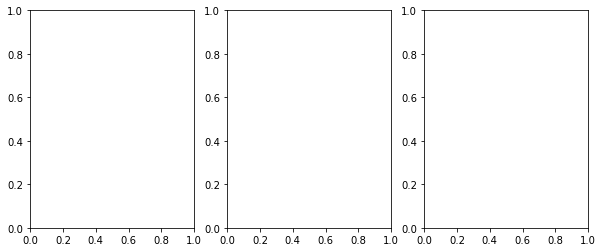

In [41]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import time as deez

fig, axs = plt.subplots(1,3, figsize=(10,4))

def _compute_transient_time(reaction_network):
    enzyme_concs = reaction_network.initial_concentrations[reaction_network.michaelis_menten_reactions.enzyme_indices[1:]]
    kms, kcats = reaction_network.michaelis_menten_reactions.Kms[1:], reaction_network.michaelis_menten_reactions.kcats[1:]
    return np.divide(kms, np.vstack([enzyme_concs, kcats]).prod(axis=0)).sum()

def _compute_equilibrium_product(reaction_network, initial_concentrations):
    substrate_concentrations = initial_concentrations[reaction_network.michaelis_menten_reactions.substrate_indices]
    return np.vstack([substrate_concentrations, reaction_network.michaelis_menten_reactions.substrate_stoichiometries]).prod(axis=0).sum()

def mm_model(x, v_max, Km):
    return v_max * x / (x + Km)

def _fit_linear_portion():
    pass

def plot_apparent_MM_curve(reaction_network, axs, cutoff=0.5):

    Km, kcat, enzyme = reaction_network.michaelis_menten_reactions.Kms[0], reaction_network.michaelis_menten_reactions.kcats[0], reaction_network.initial_concentrations[reaction_network.michaelis_menten_reactions.enzyme_indices[0]]
    substrate_concs = np.linspace(Km / 10, Km * 10, 4)

    transient_time = _compute_transient_time(reaction_network)
    inds = np.where(reaction_network.time > transient_time)[0]
    timestep = reaction_network.time[1] - reaction_network.time[0]

    observed_rates = []
    initial_concentrations = reaction_network.initial_concentrations.copy()

    for index, conc in enumerate(substrate_concs):

        initial_concentrations[reaction_network.michaelis_menten_reactions.substrate_indices[0]] = conc
        equilibrium_product = _compute_equilibrium_product(reaction_network, initial_concentrations)

        reaction_network.integrate(initial_concentrations, reaction_network.time)

        _SS_regime = reaction_network.concentrations[reaction_network.michaelis_menten_reactions.product_indices[-1],inds]
        SS_regime = _SS_regime[_SS_regime < cutoff * equilibrium_product]
        observed_rate = linregress(reaction_network.time[inds][0:len(SS_regime)], SS_regime).slope

        observed_rates.append(observed_rate)

    params, _ = curve_fit(mm_model, substrate_concs, observed_rates)
    x = np.linspace(0, Km * 10)
    axs[2].plot(x, mm_model(x, params[0], params[1]))
    axs[2].plot(x, mm_model(x, kcat * enzyme, Km))

def plot_transient_time_trace():
    pass

In [45]:
a = np.array([0,1,2,3,4,5,6,7,8])
linregress(a,a)

LinregressResult(slope=1.0, intercept=0.0, rvalue=1.0, pvalue=3.292585384803146e-70, stderr=0.0, intercept_stderr=0.0)

In [35]:
def gayma():
    return 

a = np.ndarray 
print(a)

<class 'numpy.ndarray'>


In [18]:
class Deez:
    def __init__(self):
        self.list = [1, 2, 3]

In [21]:
obj = Deez()
copy = obj.list
copy[0] = 'sugon'
copy, obj.list

(['sugon', 2, 3], ['sugon', 2, 3])

In [22]:
a = [1,2,3]
b = a
b[1] = 'deez'
a, b

([1, 'deez', 3], [1, 'deez', 3])

In [24]:
-np.array([1,2,3])

array([-1, -2, -3])

In [25]:
np.full(10, 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])